# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import stats
import cv2
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


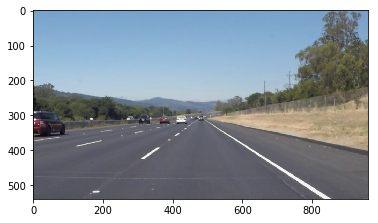

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [19]:
### import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Get image size
    image_size = img.shape
    print(image_size[0])
    
    # Look at left side of image.
    
    # Define empty lists
    x_vect_l = []
    y_vect_l = []
    x_vect_r = []
    y_vect_r = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            
            if x2 < image_size[1]/2:
                
                x_vect_l.append(x1)
                x_vect_l.append(x2)
                y_vect_l.append(y1)
                y_vect_l.append(y2)

            else:
                x_vect_r.append(x1)
                x_vect_r.append(x2)
                y_vect_r.append(y1)
                y_vect_r.append(y2)
    
    (m_l, c_l) = linear_regress(x_vect_l, y_vect_l)
    (m_r, c_r) = linear_regress(x_vect_r, y_vect_r)
    
    print(m_l)
    print(m_r)
    
    x_new1 = int((540 - c_l) / m_l)
    x_new2 = int((335 - c_l) / m_l)
    cv2.line(img, (x_new1, 540), (x_new2, 335), color, thickness)
    
    x_new1 = int((540 - c_r) / m_r)
    x_new2 = int((335 - c_r) / m_r)
    cv2.line(img, (x_new1, 540), (x_new2, 335), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def recursive_average(x, x_z, n):
    return (x_z * (n-1) + x)/n

# def linear_regress(lines)
def linear_regress(x_vect, y_vect):
    
    # Fit a line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_vect,y_vect)
    
    return (slope, intercept)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

imshape =  (540, 960, 3)
540
-0.754171385555
0.567834517836


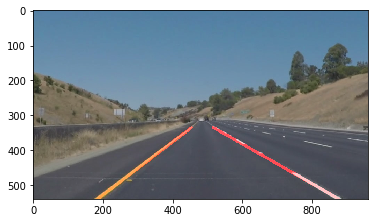

In [18]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# Read number of images
# Pass image as argument to a function
# Create function that takes in an image and performs a string of functions
image_list = []
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image_list.append(image)
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image_list.append(image)
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image_list.append(image)
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image_list.append(image)
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image_list.append(image)
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image_list.append(image)

k = 5
image = image_list[k]

# Read in and grayscale the image -----
gray = grayscale(image)

# Test checkpoint
# plt.imshow(gray, cmap = 'gray')
# ---

# Define a kernel size and apply Gaussian smoothing -----
blur_gray = gaussian_blur(gray, 3)

# Test checkpoint
# plt.imshow(blur_gray, cmap = 'gray')
# ---

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

# Test checkpoint
# plt.imshow(edges, cmap = 'gray')
# ---

# Next we'll create a masked edges image using cv2.fillPoly()
imshape = image.shape
print("imshape = ", imshape)
y = 335
vertices = np.array([[(0,imshape[0]),(450, y), (490, y), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

# Test checkpoint
# plt.imshow(masked_edges, cmap = 'gray')
# ---

# Define the Hough transform parameters ---
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 10 # maximum gap in pixels between connectable line segments
line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
# plt.imshow(line_image)
# ---

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
# plt.imshow(color_edges)
# ---

# Draw the lines on the edge image
final = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

plt.imshow(final)

c## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Read in and grayscale the image -----
    gray = grayscale(image)

    # Test checkpoint
    # plt.imshow(gray, cmap = 'gray')
    # ---

    # Define a kernel size and apply Gaussian smoothing -----
    blur_gray = gaussian_blur(gray, 3)

    # Test checkpoint
    # plt.imshow(blur_gray, cmap = 'gray')
    # ---

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Test checkpoint
    # plt.imshow(edges, cmap = 'gray')
    # ---

    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image.shape
    y = 335
    vertices = np.array([[(0,imshape[0]),(450, y), (500, y), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Test checkpoint
    # plt.imshow(masked_edges, cmap = 'gray')
    # ---

    # Define the Hough transform parameters ---
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    # plt.imshow(line_image)
    # ---

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    # plt.imshow(color_edges)
    # ---

    # Draw the lines on the edge image
    final = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    plt.imshow(final)
    
    return final

Let's try the one with the solid white lane on the right first ...

540
-0.730168246786
0.610860634222
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4





  0%|          | 0/222 [00:00<?, ?it/s]

540
-0.730168246786
0.610860634222





  0%|          | 1/222 [00:00<00:30,  7.18it/s]

540
-0.720778119488
0.623955043368





  1%|          | 2/222 [00:00<00:31,  6.95it/s]

540
-0.739711641153
0.599705234661





  1%|▏         | 3/222 [00:00<00:31,  6.85it/s]

540
-0.713830256155
0.614718309386





  2%|▏         | 4/222 [00:00<00:31,  6.82it/s]

540
-0.709582589765
0.622178925601





  2%|▏         | 5/222 [00:00<00:32,  6.68it/s]

540
-0.655902404019
0.61550012197





  3%|▎         | 6/222 [00:00<00:32,  6.62it/s]

540
-0.714193151618
0.612468686722





  3%|▎         | 7/222 [00:01<00:32,  6.53it/s]

540
-0.718659238287
0.60551618025





  4%|▎         | 8/222 [00:01<00:32,  6.56it/s]

540
-0.716895520779
0.607384794922





  4%|▍         | 9/222 [00:01<00:31,  6.66it/s]

540
-0.701838547525
0.614920305059





  5%|▍         | 10/222 [00:01<00:31,  6.75it/s]

540
-0.722449126685
0.62033393982





  5%|▍         | 11/222 [00:01<00:31,  6.77it/s]

540
-0.680537038776
0.640405719082





  5%|▌         | 12/222 [00:01<00:31,  6.59it/s]

540
-0.70582095051
0.626792522839





  6%|▌         | 13/222 [00:01<00:31,  6.68it/s]

540
-0.701011486371
0.615089990721





  6%|▋         | 14/222 [00:02<00:31,  6.63it/s]

540
-0.68874441284
0.627155311438





  7%|▋         | 15/222 [00:02<00:31,  6.67it/s]

540
-0.701200261602
0.646294605653





  7%|▋         | 16/222 [00:02<00:31,  6.58it/s]

540
-0.617773847684
0.638876793093





  8%|▊         | 17/222 [00:02<00:31,  6.42it/s]

540
-0.664117647059
0.635610551281





  8%|▊         | 18/222 [00:02<00:31,  6.52it/s]

540
-0.625719988594
0.640513423781





  9%|▊         | 19/222 [00:02<00:30,  6.56it/s]

540
-0.700316865265
0.640473797407





  9%|▉         | 20/222 [00:03<00:31,  6.51it/s]

540
-0.70048140509
0.642907128785





  9%|▉         | 21/222 [00:03<00:30,  6.70it/s]

540
-0.679286692664
0.640806171669





 10%|▉         | 22/222 [00:03<00:29,  6.81it/s]

540
-0.678742373111
0.63335178769





 10%|█         | 23/222 [00:03<00:29,  6.84it/s]

540
-0.693019081044
0.627566615634





 11%|█         | 24/222 [00:03<00:28,  6.92it/s]

540
-0.654501630346
0.636537575309





 11%|█▏        | 25/222 [00:03<00:28,  6.91it/s]

540
-0.685475708502
0.651439260595





 12%|█▏        | 26/222 [00:03<00:28,  6.99it/s]

540
-0.713675204479
0.645211714727





 12%|█▏        | 27/222 [00:04<00:28,  6.93it/s]

540
-0.706863178222
0.636931757152





 13%|█▎        | 28/222 [00:04<00:28,  6.74it/s]

540
-0.679552576573
0.637104840473





 13%|█▎        | 29/222 [00:04<00:29,  6.58it/s]

540
-0.694689896632
0.629480501991





 14%|█▎        | 30/222 [00:04<00:29,  6.46it/s]

540
-0.690272876499
0.635123879284





 14%|█▍        | 31/222 [00:04<00:28,  6.62it/s]

540
-0.699599936486
0.628407743975





 14%|█▍        | 32/222 [00:04<00:28,  6.62it/s]

540
-0.696199900122
0.633749197157





 15%|█▍        | 33/222 [00:04<00:28,  6.75it/s]

540
-0.69355805423
0.631206920232





 15%|█▌        | 34/222 [00:05<00:28,  6.61it/s]

540
-0.702013095439
0.631778719528





 16%|█▌        | 35/222 [00:05<00:28,  6.50it/s]

540
-0.699610366135
0.622025962234





 16%|█▌        | 36/222 [00:05<00:28,  6.52it/s]

540
-0.723112662498
0.626252789511





 17%|█▋        | 37/222 [00:05<00:27,  6.63it/s]

540
-0.686396956643
0.623910113066





 17%|█▋        | 38/222 [00:05<00:27,  6.75it/s]

540
-0.711990837638
0.628241116799





 18%|█▊        | 39/222 [00:05<00:27,  6.57it/s]

540
-0.699451696978
0.626387905305





 18%|█▊        | 40/222 [00:06<00:28,  6.41it/s]

540
-0.688142370865
0.638035903903





 18%|█▊        | 41/222 [00:06<00:28,  6.32it/s]

540
-0.690119899619
0.6335921837





 19%|█▉        | 42/222 [00:06<00:28,  6.23it/s]

540
-0.679805105083
0.652508397791





 19%|█▉        | 43/222 [00:06<00:28,  6.30it/s]

540
-0.716172809765
0.655501328002





 20%|█▉        | 44/222 [00:06<00:29,  6.08it/s]

540
-0.712764330967
0.651819106793





 20%|██        | 45/222 [00:06<00:28,  6.21it/s]

540
-0.703126931158
0.635787363805





 21%|██        | 46/222 [00:06<00:27,  6.40it/s]

540
-0.716704206932
0.655400386308





 21%|██        | 47/222 [00:07<00:27,  6.40it/s]

540
-0.710398503726
0.645165486492





 22%|██▏       | 48/222 [00:07<00:27,  6.38it/s]

540
-0.69971746653
0.655644357088





 22%|██▏       | 49/222 [00:07<00:27,  6.39it/s]

540
-0.709891779001
0.650125025706





 23%|██▎       | 50/222 [00:07<00:26,  6.57it/s]

540
-0.719759360927
0.650540966086





 23%|██▎       | 51/222 [00:07<00:26,  6.46it/s]

540
-0.706077166198
0.656405843619





 23%|██▎       | 52/222 [00:07<00:26,  6.34it/s]

540
-0.702161270375
0.644787066836





 24%|██▍       | 53/222 [00:08<00:26,  6.33it/s]

540
-0.632750397456
0.645339999408





 24%|██▍       | 54/222 [00:08<00:26,  6.28it/s]

540
-0.65870355844
0.637743248982





 25%|██▍       | 55/222 [00:08<00:26,  6.38it/s]

540
-0.651515151515
0.642193683036





 25%|██▌       | 56/222 [00:08<00:25,  6.57it/s]

540
-0.701406437399
0.641536393561





 26%|██▌       | 57/222 [00:08<00:25,  6.51it/s]

540
-0.659896051138
0.646373160929





 26%|██▌       | 58/222 [00:08<00:24,  6.66it/s]

540
-0.683092482882
0.659875193923





 27%|██▋       | 59/222 [00:08<00:23,  6.86it/s]

540
-0.663922728748
0.644248089068





 27%|██▋       | 60/222 [00:09<00:25,  6.48it/s]


 27%|██▋       | 61/222 [00:09<00:27,  5.83it/s]

540
-0.662295331465
0.648198361104
540
-0.691430285903
0.655350027039





 28%|██▊       | 62/222 [00:09<00:27,  5.77it/s]


 28%|██▊       | 63/222 [00:09<00:26,  6.07it/s]

540
-0.688835738775
0.651323758957
540
-0.680947817186
0.659676627064





 29%|██▉       | 64/222 [00:09<00:25,  6.17it/s]


 29%|██▉       | 65/222 [00:10<00:25,  6.06it/s]

540
-0.654874789075
0.658436591493
540
-0.622924128948
0.664951493771





 30%|██▉       | 66/222 [00:10<00:25,  6.20it/s]


 30%|███       | 67/222 [00:10<00:24,  6.33it/s]

540
-0.629229323308
0.648879389085
540
-0.673914031147
0.64910802553





 31%|███       | 68/222 [00:10<00:24,  6.32it/s]


 31%|███       | 69/222 [00:10<00:23,  6.42it/s]

540
-0.670960577975
0.658315944832
540
-0.634798552629
0.658250662355





 32%|███▏      | 70/222 [00:10<00:23,  6.48it/s]


 32%|███▏      | 71/222 [00:10<00:22,  6.65it/s]

540
-0.649034559787
0.646571507625
540
-0.661829957383
0.653127950283





 32%|███▏      | 72/222 [00:11<00:22,  6.72it/s]


 33%|███▎      | 73/222 [00:11<00:21,  6.85it/s]

540
-0.65742742066
0.65730287598
540
-0.658621654952
0.664314330382





 33%|███▎      | 74/222 [00:11<00:22,  6.72it/s]


 34%|███▍      | 75/222 [00:11<00:21,  6.71it/s]

540
-0.660568461137
0.655975262604
540
-0.669851385826
0.650473090509





 34%|███▍      | 76/222 [00:11<00:21,  6.70it/s]


 35%|███▍      | 77/222 [00:11<00:21,  6.75it/s]

540
-0.671576281499
0.656872012936
540
-0.631911247407
0.656943801928





 35%|███▌      | 78/222 [00:11<00:21,  6.69it/s]


 36%|███▌      | 79/222 [00:12<00:21,  6.75it/s]

540
-0.616303249955
0.673058845083
540
-0.628826788531
0.674650657545





 36%|███▌      | 80/222 [00:12<00:20,  6.78it/s]


 36%|███▋      | 81/222 [00:12<00:21,  6.51it/s]

540
-0.649028373324
0.694145759252
540
-0.635870087441
0.681827369669





 37%|███▋      | 82/222 [00:12<00:21,  6.53it/s]


 37%|███▋      | 83/222 [00:12<00:21,  6.58it/s]

540
-0.643728616616
0.668114386585
540
-0.641959224877
0.675583208831





 38%|███▊      | 84/222 [00:12<00:20,  6.64it/s]


 38%|███▊      | 85/222 [00:13<00:20,  6.61it/s]

540
-0.639062139062
0.674441008271
540
-0.64052636942
0.685337087537





 39%|███▊      | 86/222 [00:13<00:20,  6.62it/s]


 39%|███▉      | 87/222 [00:13<00:21,  6.35it/s]

540
-0.675049220372
0.674712736782
540
-0.653222452124
0.677978734678





 40%|███▉      | 88/222 [00:13<00:21,  6.12it/s]


 40%|████      | 89/222 [00:13<00:21,  6.11it/s]

540
-0.651488379073
0.683972674205
540
-0.62288686606
0.685959125826





 41%|████      | 90/222 [00:13<00:21,  6.03it/s]


 41%|████      | 91/222 [00:14<00:21,  6.08it/s]

540
-0.611843575419
0.680736723023
540
-0.667141128745
0.675914932218





 41%|████▏     | 92/222 [00:14<00:21,  6.04it/s]


 42%|████▏     | 93/222 [00:14<00:20,  6.18it/s]

540
-0.613829628525
0.673065152116
540
-0.607299649305
0.695583735696





 42%|████▏     | 94/222 [00:14<00:20,  6.10it/s]


 43%|████▎     | 95/222 [00:14<00:20,  6.09it/s]

540
-0.636249115983
0.688920074574
540
-0.648020149953
0.68861043494





 43%|████▎     | 96/222 [00:14<00:22,  5.66it/s]


 44%|████▎     | 97/222 [00:15<00:21,  5.70it/s]

540
-0.652402406636
0.696141944735
540
-0.656336009816
0.708286902524





 44%|████▍     | 98/222 [00:15<00:20,  5.92it/s]


 45%|████▍     | 99/222 [00:15<00:20,  5.99it/s]

540
-0.669394676606
0.692070735881
540
-0.656217640588
0.696019135389





 45%|████▌     | 100/222 [00:15<00:20,  6.00it/s]


 45%|████▌     | 101/222 [00:15<00:20,  5.97it/s]

540
-0.653788963728
0.687789935432
540
-0.603840211874
0.685299283909





 46%|████▌     | 102/222 [00:15<00:19,  6.22it/s]


 46%|████▋     | 103/222 [00:15<00:18,  6.36it/s]

540
-0.606723826715
0.693583170922
540
-0.637767169828
0.682106235636





 47%|████▋     | 104/222 [00:16<00:18,  6.48it/s]


 47%|████▋     | 105/222 [00:16<00:17,  6.52it/s]

540
-0.639085465433
0.67094907024
540
-0.645044417349
0.687591892026





 48%|████▊     | 106/222 [00:16<00:18,  6.38it/s]


 48%|████▊     | 107/222 [00:16<00:17,  6.48it/s]

540
-0.66131003411
0.673693329196
540
-0.647508989503
0.680366564134





 49%|████▊     | 108/222 [00:16<00:17,  6.64it/s]


 49%|████▉     | 109/222 [00:16<00:16,  6.71it/s]

540
-0.646722523411
0.673141291081
540
-0.662824379102
0.668255261763





 50%|████▉     | 110/222 [00:17<00:16,  6.68it/s]


 50%|█████     | 111/222 [00:17<00:16,  6.82it/s]

540
-0.697271315
0.681034701086
540
-0.695495732935
0.688446503731





 50%|█████     | 112/222 [00:17<00:16,  6.64it/s]


 51%|█████     | 113/222 [00:17<00:18,  6.02it/s]

540
-0.702086352948
0.671146693616
540





 51%|█████▏    | 114/222 [00:17<00:18,  5.87it/s]

-0.649390687258
0.677654574373
540
-0.64744351962
0.677352791343





 52%|█████▏    | 115/222 [00:17<00:18,  5.80it/s]


 52%|█████▏    | 116/222 [00:18<00:18,  5.87it/s]

540
-0.678341013825
0.679653209003
540
-0.69778788348
0.679977569953





 53%|█████▎    | 117/222 [00:18<00:17,  6.05it/s]


 53%|█████▎    | 118/222 [00:18<00:16,  6.22it/s]

540
-0.686399916803
0.666975584276
540
-0.679306929229
0.65871860721





 54%|█████▎    | 119/222 [00:18<00:16,  6.41it/s]


 54%|█████▍    | 120/222 [00:18<00:16,  6.30it/s]

540
-0.649268376927
0.665760781602
540
-0.672396299163
0.642545490347





 55%|█████▍    | 121/222 [00:18<00:15,  6.45it/s]


 55%|█████▍    | 122/222 [00:18<00:15,  6.53it/s]

540
-0.680823314793
0.648672468488
540
-0.677330509531
0.650838461842





 55%|█████▌    | 123/222 [00:19<00:15,  6.55it/s]


 56%|█████▌    | 124/222 [00:19<00:15,  6.51it/s]

540
-0.665111628122
0.651153923432
540
-0.660898752395
0.63186379787





 56%|█████▋    | 125/222 [00:19<00:15,  6.44it/s]


 57%|█████▋    | 126/222 [00:19<00:15,  6.34it/s]

540
-0.648381971737
0.633424577045
540
-0.657894736842
0.64326697024





 57%|█████▋    | 127/222 [00:19<00:15,  6.33it/s]


 58%|█████▊    | 128/222 [00:19<00:14,  6.48it/s]

540
-0.65521521124
0.634801492974
540
-0.686175848558
0.635336840767





 58%|█████▊    | 129/222 [00:20<00:13,  6.64it/s]


 59%|█████▊    | 130/222 [00:20<00:13,  6.66it/s]

540
-0.678763192001
0.625271443081
540
-0.693625588589
0.627752718673





 59%|█████▉    | 131/222 [00:20<00:13,  6.68it/s]


 59%|█████▉    | 132/222 [00:20<00:13,  6.63it/s]

540
-0.714257634143
0.628331371752
540
-0.700032214483
0.628276141526





 60%|█████▉    | 133/222 [00:20<00:13,  6.62it/s]


 60%|██████    | 134/222 [00:20<00:13,  6.63it/s]

540
-0.69371750815
0.641068075884
540
-0.678266314523
0.645617367082





 61%|██████    | 135/222 [00:20<00:13,  6.40it/s]


 61%|██████▏   | 136/222 [00:21<00:14,  6.07it/s]

540
-0.687583525696
0.653334030769
540
-0.710211325052
0.634203016078





 62%|██████▏   | 137/222 [00:21<00:14,  6.01it/s]


 62%|██████▏   | 138/222 [00:21<00:13,  6.21it/s]

540
-0.684114424833
0.626845350956
540
-0.649360548827
0.627781243736





 63%|██████▎   | 139/222 [00:21<00:13,  6.36it/s]


 63%|██████▎   | 140/222 [00:21<00:12,  6.34it/s]

540
-0.701148889127
0.634582453905
540
-0.70022727702
0.625612407887





 64%|██████▎   | 141/222 [00:21<00:12,  6.54it/s]


 64%|██████▍   | 142/222 [00:22<00:12,  6.52it/s]

540
-0.68873603759
0.625485492568
540
-0.714286529518
0.622759342844





 64%|██████▍   | 143/222 [00:22<00:11,  6.59it/s]


 65%|██████▍   | 144/222 [00:22<00:11,  6.62it/s]

540
-0.728117258464
0.634608048259
540
-0.715254980765
0.634006028305





 65%|██████▌   | 145/222 [00:22<00:11,  6.72it/s]


 66%|██████▌   | 146/222 [00:22<00:11,  6.63it/s]

540
-0.718334622688
0.636031295274
540
-0.724312501998
0.616435232341





 66%|██████▌   | 147/222 [00:22<00:11,  6.56it/s]


 67%|██████▋   | 148/222 [00:23<00:11,  6.20it/s]

540
-0.706244178236
0.614837989577
540
-0.71790657165
0.615490995854





 67%|██████▋   | 149/222 [00:23<00:11,  6.23it/s]


 68%|██████▊   | 150/222 [00:23<00:11,  6.37it/s]

540
-0.690277273278
0.607231414573
540
-0.684820827411
0.609205651194





 68%|██████▊   | 151/222 [00:23<00:10,  6.62it/s]


 68%|██████▊   | 152/222 [00:23<00:10,  6.60it/s]

540
-0.710056957288
0.620700938083
540
-0.719451150484
0.62911277769





 69%|██████▉   | 153/222 [00:23<00:10,  6.74it/s]


 69%|██████▉   | 154/222 [00:23<00:10,  6.73it/s]

540
-0.698262143525
0.615055656902
540
-0.71032799591
0.621528486829





 70%|██████▉   | 155/222 [00:24<00:09,  6.71it/s]


 70%|███████   | 156/222 [00:24<00:10,  6.53it/s]

540
-0.698360492102
0.629975785509
540
-0.712930024463
0.607813986723





 71%|███████   | 157/222 [00:24<00:10,  6.38it/s]


 71%|███████   | 158/222 [00:24<00:09,  6.47it/s]

540
-0.734404140496
0.621495416928
540
-0.71918551281
0.621821498771





 72%|███████▏  | 159/222 [00:24<00:09,  6.58it/s]


 72%|███████▏  | 160/222 [00:24<00:09,  6.55it/s]

540
-0.738177322211
0.606121205149
540
-0.726206691545
0.610353647687





 73%|███████▎  | 161/222 [00:24<00:09,  6.54it/s]


 73%|███████▎  | 162/222 [00:25<00:08,  6.70it/s]

540
-0.747991467475
0.594807421979
540
-0.70915035292
0.601292271697





 73%|███████▎  | 163/222 [00:25<00:08,  6.76it/s]


 74%|███████▍  | 164/222 [00:25<00:08,  6.65it/s]

540
-0.700136301681
0.592995923711
540
-0.748726961859
0.58867508375





 74%|███████▍  | 165/222 [00:25<00:08,  6.50it/s]


 75%|███████▍  | 166/222 [00:25<00:08,  6.62it/s]

540
-0.759929620336
0.58437287041
540
-0.750727537391
0.587879890994





 75%|███████▌  | 167/222 [00:25<00:08,  6.72it/s]


 76%|███████▌  | 168/222 [00:26<00:08,  6.51it/s]

540
-0.756342884279
0.578368912671
540
-0.75884442052
0.58292887361





 76%|███████▌  | 169/222 [00:26<00:08,  6.47it/s]


 77%|███████▋  | 170/222 [00:26<00:07,  6.65it/s]

540
-0.773063676485
0.58169618646
540
-0.771273071462
0.585724494017





 77%|███████▋  | 171/222 [00:26<00:07,  6.70it/s]


 77%|███████▋  | 172/222 [00:26<00:07,  6.67it/s]

540
-0.724565816845
0.579684503518
540
-0.780463527456
0.58540592406





 78%|███████▊  | 173/222 [00:26<00:07,  6.67it/s]


 78%|███████▊  | 174/222 [00:26<00:07,  6.74it/s]

540
-0.778965517241
0.585019349198
540
-0.790678637444
0.581459996522





 79%|███████▉  | 175/222 [00:27<00:07,  6.52it/s]


 79%|███████▉  | 176/222 [00:27<00:07,  6.53it/s]

540
-0.763384131405
0.580016107101
540
-0.769795617801
0.571575334931





 80%|███████▉  | 177/222 [00:27<00:07,  6.41it/s]


 80%|████████  | 178/222 [00:27<00:06,  6.55it/s]

540
-0.780512148275
0.578223428159
540
-0.796410853716
0.580214548107





 81%|████████  | 179/222 [00:27<00:06,  6.60it/s]


 81%|████████  | 180/222 [00:27<00:06,  6.58it/s]

540
-0.7764346398
0.59238401749
540
-0.788372573645
0.567927149011





 82%|████████▏ | 181/222 [00:28<00:06,  6.35it/s]


 82%|████████▏ | 182/222 [00:28<00:06,  6.44it/s]

540
-0.799986703482
0.569753959192
540
-0.764790973528
0.576089651996





 82%|████████▏ | 183/222 [00:28<00:06,  6.42it/s]


 83%|████████▎ | 184/222 [00:28<00:05,  6.43it/s]

540
-0.802011437586
0.609040761048
540
-0.809442291533
0.59425003448





 83%|████████▎ | 185/222 [00:28<00:05,  6.59it/s]


 84%|████████▍ | 186/222 [00:28<00:05,  6.72it/s]

540
-0.802927161334
0.584039059888
540
-0.76653751156
0.594131080463





 84%|████████▍ | 187/222 [00:28<00:05,  6.78it/s]


 85%|████████▍ | 188/222 [00:29<00:05,  6.76it/s]

540
-0.782253523187
0.58492900489
540
-0.751683501684
0.562176175834





 85%|████████▌ | 189/222 [00:29<00:04,  6.71it/s]


 86%|████████▌ | 190/222 [00:29<00:04,  6.62it/s]

540
-0.760935371576
0.573866157403
540
-0.742264767262
0.57294788746





 86%|████████▌ | 191/222 [00:29<00:04,  6.37it/s]


 86%|████████▋ | 192/222 [00:29<00:04,  6.24it/s]

540
-0.778802287787
0.554675816077
540
-0.7898758048
0.574618200105





 87%|████████▋ | 193/222 [00:29<00:04,  6.08it/s]


 87%|████████▋ | 194/222 [00:30<00:04,  6.10it/s]

540
-0.780324089608
0.578980452404
540
-0.773915619219
0.584805118913





 88%|████████▊ | 195/222 [00:30<00:04,  6.21it/s]


 88%|████████▊ | 196/222 [00:30<00:04,  6.17it/s]

540
-0.778107555956
0.585695186642
540
-0.785374292004
0.579902045572





 89%|████████▊ | 197/222 [00:30<00:04,  6.06it/s]


 89%|████████▉ | 198/222 [00:30<00:04,  5.95it/s]

540
-0.718107406668
0.583653674236
540
-0.712214938602
0.575929643507





 90%|████████▉ | 199/222 [00:30<00:03,  6.08it/s]


 90%|█████████ | 200/222 [00:31<00:03,  5.73it/s]

540
-0.804870946701
0.572151221662





 91%|█████████ | 201/222 [00:31<00:03,  5.67it/s]

540
-0.880196016645
0.569258835677
540
-0.874281633283
0.575146861894





 91%|█████████ | 202/222 [00:31<00:03,  5.73it/s]


 91%|█████████▏| 203/222 [00:31<00:03,  5.51it/s]

540
-0.780156095471
0.571669692287





 92%|█████████▏| 204/222 [00:31<00:03,  4.82it/s]

540
-0.780160451614
0.56851466024





 92%|█████████▏| 205/222 [00:32<00:03,  4.76it/s]

540
-0.789193933571
0.570462978439


540
-0.79523874365
0.570178658336


 93%|█████████▎| 206/222 [00:32<00:03,  4.62it/s]


 93%|█████████▎| 207/222 [00:32<00:03,  4.47it/s]

540
-0.763636550512
0.568667099728





 94%|█████████▎| 208/222 [00:32<00:03,  4.41it/s]

540
-0.745042726668
0.568268048103





 94%|█████████▍| 209/222 [00:33<00:02,  4.36it/s]

540
-0.708444444444
0.561477371291





 95%|█████████▍| 210/222 [00:33<00:02,  4.38it/s]

540
-0.710574293528
0.560145215475





 95%|█████████▌| 211/222 [00:33<00:02,  4.36it/s]

540
-0.743064729194
0.552412406112





 95%|█████████▌| 212/222 [00:33<00:02,  4.32it/s]

540
-0.780641934897
0.548704807548





 96%|█████████▌| 213/222 [00:33<00:02,  4.44it/s]

540
-0.803259392524
0.556368947309
540





 96%|█████████▋| 214/222 [00:34<00:01,  4.49it/s]

-0.799854110304
0.561140487922
540
-0.770557294928
0.563171628181





 97%|█████████▋| 215/222 [00:34<00:01,  4.65it/s]


 97%|█████████▋| 216/222 [00:34<00:01,  4.63it/s]

540
-0.786464941016
0.574671035092





 98%|█████████▊| 217/222 [00:34<00:01,  4.75it/s]

540
-0.766677393252
0.565573263809
540
-0.782153048404
0.560183812488





 98%|█████████▊| 218/222 [00:34<00:00,  4.82it/s]


 99%|█████████▊| 219/222 [00:35<00:00,  4.88it/s]

540
-0.759809964539
0.56478427891
540
-0.777256750542




 99%|█████████▉| 220/222 [00:35<00:00,  4.81it/s]


0.565254586451





100%|█████████▉| 221/222 [00:35<00:00,  4.62it/s]




540
-0.790099948514
0.563775554065
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 33.1 s, sys: 1.35 s, total: 34.5 s
Wall time: 37.2 s


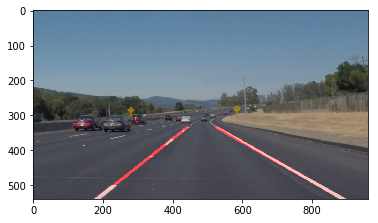

In [22]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,1)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

540
-0.61726275023
0.659932240709
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4





  0%|          | 0/101 [00:00<?, ?it/s]

540
-0.61726275023
0.659932240709





  1%|          | 1/101 [00:00<00:14,  6.80it/s]

540
-0.619776898989
0.684999010053





  2%|▏         | 2/101 [00:00<00:15,  6.54it/s]

540
-0.622785911516
0.663899478419





  3%|▎         | 3/101 [00:00<00:14,  6.57it/s]

540
-0.622972206222
0.648872226233





  4%|▍         | 4/101 [00:00<00:14,  6.70it/s]

540
-0.622038129357
0.672623449182





  5%|▍         | 5/101 [00:00<00:14,  6.42it/s]

540
-0.629608635285
0.590255068672





  6%|▌         | 6/101 [00:00<00:14,  6.44it/s]

540
-0.643559790162
0.613418966931





  7%|▋         | 7/101 [00:01<00:14,  6.61it/s]

540
-0.645991033681
0.645967232034





  8%|▊         | 8/101 [00:01<00:13,  6.64it/s]

540
-0.644711876909
0.662133554142





  9%|▉         | 9/101 [00:01<00:14,  6.48it/s]

540
-0.639030523825
0.659030179881





 10%|▉         | 10/101 [00:01<00:13,  6.51it/s]

540
-0.646465119913
0.633390736237





 11%|█         | 11/101 [00:01<00:13,  6.49it/s]

540
-0.653526449198
0.613800465373





 12%|█▏        | 12/101 [00:01<00:13,  6.61it/s]

540
-0.654629030564
0.628800910933





 13%|█▎        | 13/101 [00:01<00:13,  6.57it/s]

540
-0.656637550263
0.612081075657





 14%|█▍        | 14/101 [00:02<00:13,  6.67it/s]

540
-0.677180808558
0.628507656218





 15%|█▍        | 15/101 [00:02<00:13,  6.58it/s]

540
-0.681251577346
0.622667445344





 16%|█▌        | 16/101 [00:02<00:12,  6.63it/s]

540
-0.667026055116
0.574352509931





 17%|█▋        | 17/101 [00:02<00:12,  6.76it/s]

540
-0.680181386942
0.592592592593





 18%|█▊        | 18/101 [00:02<00:12,  6.74it/s]

540
-0.686111892568
0.612903225806





 19%|█▉        | 19/101 [00:02<00:12,  6.77it/s]

540
-0.683492411117
0.619451603666





 20%|█▉        | 20/101 [00:03<00:12,  6.61it/s]

540
-0.68934586889
0.62124137931





 21%|██        | 21/101 [00:03<00:11,  6.68it/s]

540
-0.67507301824
0.624949358821





 22%|██▏       | 22/101 [00:03<00:11,  6.64it/s]

540
-0.680345175562
0.625251890533





 23%|██▎       | 23/101 [00:03<00:11,  6.59it/s]

540
-0.676885557055
0.583949333949





 24%|██▍       | 24/101 [00:03<00:11,  6.70it/s]

540
-0.675499848004
0.613849082929





 25%|██▍       | 25/101 [00:03<00:11,  6.70it/s]

540
-0.678678732445
0.617544442598





 26%|██▌       | 26/101 [00:03<00:11,  6.70it/s]

540
-0.705593175012
0.5968606997





 27%|██▋       | 27/101 [00:04<00:10,  6.81it/s]

540
-0.704707408526
0.589924241551





 28%|██▊       | 28/101 [00:04<00:10,  6.92it/s]

540
-0.713036160463
0.587325367991





 29%|██▊       | 29/101 [00:04<00:10,  6.73it/s]

540
-0.700217470937
0.48700771417





 30%|██▉       | 30/101 [00:04<00:10,  6.60it/s]

540


ValueError: Inputs must not be empty.

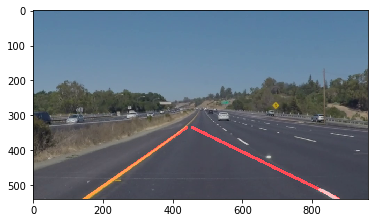

In [23]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,4)
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

720
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  0%|          | 0/251 [00:00<?, ?it/s]

720



  0%|          | 1/251 [00:00<01:04,  3.85it/s]

720



  1%|          | 2/251 [00:00<01:06,  3.73it/s]

720



  1%|          | 3/251 [00:00<01:06,  3.70it/s]

720



  2%|▏         | 4/251 [00:01<01:05,  3.76it/s]

720



  2%|▏         | 5/251 [00:01<01:04,  3.84it/s]

720



  2%|▏         | 6/251 [00:01<01:02,  3.90it/s]

720



  3%|▎         | 7/251 [00:01<01:01,  3.94it/s]

720



  3%|▎         | 8/251 [00:02<01:01,  3.98it/s]

720



  4%|▎         | 9/251 [00:02<01:00,  4.00it/s]

720



  4%|▍         | 10/251 [00:02<01:00,  4.02it/s]

720



  4%|▍         | 11/251 [00:02<00:59,  4.04it/s]

720



  5%|▍         | 12/251 [00:03<00:58,  4.05it/s]

720



  5%|▌         | 13/251 [00:03<00:59,  4.01it/s]

720



  6%|▌         | 14/251 [00:03<00:59,  3.96it/s]

720



  6%|▌         | 15/251 [00:03<01:00,  3.89it/s]

720



  6%|▋         | 16/251 [00:04<01:00,  3.88it/s]

720



  7%|▋         | 17/251 [00:04<01:00,  3.88it/s]

720



  7%|▋         | 18/251 [00:04<00:59,  3.90it/s]

720



  8%|▊         | 19/251 [00:04<00:58,  3.97it/s]

720



  8%|▊         | 20/251 [00:05<00:57,  3.99it/s]

720



  8%|▊         | 21/251 [00:05<00:59,  3.87it/s]

720



  9%|▉         | 22/251 [00:05<01:00,  3.82it/s]

720



  9%|▉         | 23/251 [00:05<00:59,  3.82it/s]

720



 10%|▉         | 24/251 [00:06<00:59,  3.84it/s]

720



 10%|▉         | 25/251 [00:06<00:58,  3.86it/s]


720


 11%|█         | 27/251 [00:06<00:57,  3.92it/s]

720


720



 11%|█         | 28/251 [00:07<00:57,  3.88it/s]

720



 12%|█▏        | 29/251 [00:07<00:56,  3.90it/s]

720



 12%|█▏        | 30/251 [00:07<00:56,  3.88it/s]

720



 12%|█▏        | 31/251 [00:07<00:56,  3.89it/s]

720



 13%|█▎        | 32/251 [00:08<00:56,  3.88it/s]

720



 13%|█▎        | 33/251 [00:08<00:56,  3.88it/s]

720



 14%|█▎        | 34/251 [00:08<00:55,  3.88it/s]

720



 14%|█▍        | 35/251 [00:08<00:55,  3.87it/s]

720



 14%|█▍        | 36/251 [00:09<00:55,  3.86it/s]

720



 15%|█▍        | 37/251 [00:09<00:55,  3.85it/s]

720



 15%|█▌        | 38/251 [00:09<00:55,  3.81it/s]

720



 16%|█▌        | 39/251 [00:10<00:56,  3.75it/s]

720



 16%|█▌        | 40/251 [00:10<00:55,  3.78it/s]

720



 16%|█▋        | 41/251 [00:10<00:56,  3.71it/s]

720



 17%|█▋        | 42/251 [00:10<00:56,  3.68it/s]

720



 17%|█▋        | 43/251 [00:11<00:55,  3.74it/s]

720



 18%|█▊        | 44/251 [00:11<00:57,  3.61it/s]

720



 18%|█▊        | 45/251 [00:11<00:56,  3.62it/s]

720



 18%|█▊        | 46/251 [00:11<00:55,  3.70it/s]

720



 19%|█▊        | 47/251 [00:12<00:54,  3.76it/s]

720



 19%|█▉        | 48/251 [00:12<00:54,  3.72it/s]

720



 20%|█▉        | 49/251 [00:12<00:53,  3.75it/s]

720



 20%|█▉        | 50/251 [00:13<00:53,  3.73it/s]

720



 20%|██        | 51/251 [00:13<00:53,  3.73it/s]

720



 21%|██        | 52/251 [00:13<00:54,  3.66it/s]

720



 21%|██        | 53/251 [00:13<00:54,  3.66it/s]

720



 22%|██▏       | 54/251 [00:14<00:53,  3.69it/s]

720



 22%|██▏       | 55/251 [00:14<00:52,  3.73it/s]

720



 22%|██▏       | 56/251 [00:14<00:54,  3.57it/s]

720



 23%|██▎       | 57/251 [00:14<00:53,  3.64it/s]

720



 23%|██▎       | 58/251 [00:15<00:53,  3.64it/s]

720



 24%|██▎       | 59/251 [00:15<00:52,  3.66it/s]

720



 24%|██▍       | 60/251 [00:15<00:53,  3.60it/s]

720



 24%|██▍       | 61/251 [00:16<00:52,  3.61it/s]

720



 25%|██▍       | 62/251 [00:16<00:52,  3.59it/s]

720



 25%|██▌       | 63/251 [00:16<00:51,  3.62it/s]

720



 25%|██▌       | 64/251 [00:16<00:50,  3.70it/s]

720



 26%|██▌       | 65/251 [00:17<00:49,  3.73it/s]

720



 26%|██▋       | 66/251 [00:17<00:49,  3.72it/s]

720



 27%|██▋       | 67/251 [00:17<00:50,  3.68it/s]

720



 27%|██▋       | 68/251 [00:17<00:49,  3.67it/s]

720



 27%|██▋       | 69/251 [00:18<00:49,  3.70it/s]

720



 28%|██▊       | 70/251 [00:18<00:49,  3.69it/s]

720



 28%|██▊       | 71/251 [00:18<00:48,  3.72it/s]

720



 29%|██▊       | 72/251 [00:19<00:47,  3.75it/s]

720



 29%|██▉       | 73/251 [00:19<00:47,  3.78it/s]

720



 29%|██▉       | 74/251 [00:19<00:47,  3.75it/s]

720



 30%|██▉       | 75/251 [00:19<00:47,  3.73it/s]

720



 30%|███       | 76/251 [00:20<00:47,  3.66it/s]

720



 31%|███       | 77/251 [00:20<00:46,  3.72it/s]

720



 31%|███       | 78/251 [00:20<00:45,  3.79it/s]

720



 31%|███▏      | 79/251 [00:20<00:45,  3.77it/s]

720



 32%|███▏      | 80/251 [00:21<00:46,  3.71it/s]

720



 32%|███▏      | 81/251 [00:21<00:46,  3.64it/s]

720



 33%|███▎      | 82/251 [00:21<00:46,  3.66it/s]

720



 33%|███▎      | 83/251 [00:21<00:46,  3.64it/s]

720



 33%|███▎      | 84/251 [00:22<00:45,  3.65it/s]

720



 34%|███▍      | 85/251 [00:22<00:45,  3.61it/s]

720



 34%|███▍      | 86/251 [00:22<00:45,  3.65it/s]

720



 35%|███▍      | 87/251 [00:23<00:44,  3.66it/s]

720



 35%|███▌      | 88/251 [00:23<00:44,  3.69it/s]

720



 35%|███▌      | 89/251 [00:23<00:44,  3.66it/s]

720



 36%|███▌      | 90/251 [00:23<00:44,  3.62it/s]

720



 36%|███▋      | 91/251 [00:24<00:44,  3.61it/s]

720



 37%|███▋      | 92/251 [00:24<00:44,  3.57it/s]

720



 37%|███▋      | 93/251 [00:24<00:44,  3.58it/s]

720



 37%|███▋      | 94/251 [00:25<00:43,  3.57it/s]

720



 38%|███▊      | 95/251 [00:25<00:44,  3.52it/s]

720



 38%|███▊      | 96/251 [00:25<00:45,  3.39it/s]

720



 39%|███▊      | 97/251 [00:25<00:46,  3.31it/s]

720



 39%|███▉      | 98/251 [00:26<00:47,  3.23it/s]

720



 39%|███▉      | 99/251 [00:26<00:47,  3.22it/s]

720



 40%|███▉      | 100/251 [00:26<00:46,  3.22it/s]

720



 40%|████      | 101/251 [00:27<00:46,  3.24it/s]

720



 41%|████      | 102/251 [00:27<00:44,  3.32it/s]

720



 41%|████      | 103/251 [00:27<00:43,  3.38it/s]

720



 41%|████▏     | 104/251 [00:28<00:42,  3.43it/s]

720



 42%|████▏     | 105/251 [00:28<00:43,  3.34it/s]

720



 42%|████▏     | 106/251 [00:28<00:43,  3.35it/s]

720



 43%|████▎     | 107/251 [00:28<00:42,  3.41it/s]

720



 43%|████▎     | 108/251 [00:29<00:42,  3.40it/s]

720



 43%|████▎     | 109/251 [00:29<00:43,  3.26it/s]

720



 44%|████▍     | 110/251 [00:29<00:42,  3.35it/s]

720



 44%|████▍     | 111/251 [00:30<00:41,  3.36it/s]

720



 45%|████▍     | 112/251 [00:30<00:40,  3.46it/s]

720



 45%|████▌     | 113/251 [00:30<00:38,  3.54it/s]

720



 45%|████▌     | 114/251 [00:31<00:38,  3.53it/s]

720



 46%|████▌     | 115/251 [00:31<00:38,  3.57it/s]

720



 46%|████▌     | 116/251 [00:31<00:36,  3.65it/s]

720



 47%|████▋     | 117/251 [00:31<00:36,  3.67it/s]

720



 47%|████▋     | 118/251 [00:32<00:35,  3.72it/s]

720



 47%|████▋     | 119/251 [00:32<00:35,  3.75it/s]

720



 48%|████▊     | 120/251 [00:32<00:35,  3.68it/s]

720



 48%|████▊     | 121/251 [00:32<00:34,  3.73it/s]

720



 49%|████▊     | 122/251 [00:33<00:35,  3.65it/s]

720



 49%|████▉     | 123/251 [00:33<00:34,  3.67it/s]

720



 49%|████▉     | 124/251 [00:33<00:34,  3.69it/s]

720



 50%|████▉     | 125/251 [00:33<00:34,  3.63it/s]

720



 50%|█████     | 126/251 [00:34<00:34,  3.65it/s]

720



 51%|█████     | 127/251 [00:34<00:33,  3.66it/s]

720



 51%|█████     | 128/251 [00:34<00:35,  3.50it/s]

720



 51%|█████▏    | 129/251 [00:35<00:35,  3.45it/s]

720



 52%|█████▏    | 130/251 [00:35<00:35,  3.45it/s]

720



 52%|█████▏    | 131/251 [00:35<00:33,  3.56it/s]

720



 53%|█████▎    | 132/251 [00:35<00:33,  3.59it/s]

720



 53%|█████▎    | 133/251 [00:36<00:32,  3.66it/s]

720



 53%|█████▎    | 134/251 [00:36<00:31,  3.70it/s]

720



 54%|█████▍    | 135/251 [00:36<00:31,  3.73it/s]

720



 54%|█████▍    | 136/251 [00:37<00:30,  3.72it/s]

720



 55%|█████▍    | 137/251 [00:37<00:32,  3.53it/s]

720



 55%|█████▍    | 138/251 [00:37<00:31,  3.55it/s]

720



 55%|█████▌    | 139/251 [00:37<00:30,  3.62it/s]

720



 56%|█████▌    | 140/251 [00:38<00:30,  3.70it/s]

720



 56%|█████▌    | 141/251 [00:38<00:29,  3.71it/s]

720



 57%|█████▋    | 142/251 [00:38<00:29,  3.75it/s]

720



 57%|█████▋    | 143/251 [00:38<00:29,  3.70it/s]

720



 57%|█████▋    | 144/251 [00:39<00:29,  3.59it/s]

720



 58%|█████▊    | 145/251 [00:39<00:29,  3.57it/s]

720



 58%|█████▊    | 146/251 [00:39<00:29,  3.56it/s]

720



 59%|█████▊    | 147/251 [00:40<00:29,  3.55it/s]

720



 59%|█████▉    | 148/251 [00:40<00:29,  3.47it/s]

720



 59%|█████▉    | 149/251 [00:40<00:30,  3.35it/s]

720



 60%|█████▉    | 150/251 [00:41<00:30,  3.36it/s]

720



 60%|██████    | 151/251 [00:41<00:29,  3.44it/s]

720



 61%|██████    | 152/251 [00:41<00:28,  3.48it/s]

720



 61%|██████    | 153/251 [00:41<00:27,  3.52it/s]

720



 61%|██████▏   | 154/251 [00:42<00:27,  3.58it/s]

720



 62%|██████▏   | 155/251 [00:42<00:26,  3.59it/s]

720



 62%|██████▏   | 156/251 [00:42<00:26,  3.54it/s]

720



 63%|██████▎   | 157/251 [00:42<00:25,  3.65it/s]

720



 63%|██████▎   | 158/251 [00:43<00:25,  3.66it/s]

720



 63%|██████▎   | 159/251 [00:43<00:24,  3.73it/s]

720



 64%|██████▎   | 160/251 [00:43<00:24,  3.78it/s]

720



 64%|██████▍   | 161/251 [00:43<00:23,  3.76it/s]

720



 65%|██████▍   | 162/251 [00:44<00:23,  3.79it/s]

720



 65%|██████▍   | 163/251 [00:44<00:23,  3.81it/s]

720



 65%|██████▌   | 164/251 [00:44<00:23,  3.76it/s]

720



 66%|██████▌   | 165/251 [00:45<00:22,  3.76it/s]

720



 66%|██████▌   | 166/251 [00:45<00:22,  3.79it/s]

720



 67%|██████▋   | 167/251 [00:45<00:22,  3.81it/s]

720



 67%|██████▋   | 168/251 [00:45<00:22,  3.71it/s]

720



 67%|██████▋   | 169/251 [00:46<00:21,  3.76it/s]

720



 68%|██████▊   | 170/251 [00:46<00:21,  3.73it/s]

720



 68%|██████▊   | 171/251 [00:46<00:21,  3.68it/s]

720



 69%|██████▊   | 172/251 [00:46<00:21,  3.65it/s]

720



 69%|██████▉   | 173/251 [00:47<00:21,  3.58it/s]

720



 69%|██████▉   | 174/251 [00:47<00:21,  3.52it/s]

720



 70%|██████▉   | 175/251 [00:47<00:21,  3.55it/s]

720



 70%|███████   | 176/251 [00:48<00:21,  3.42it/s]

720



 71%|███████   | 177/251 [00:48<00:21,  3.38it/s]

720



 71%|███████   | 178/251 [00:48<00:21,  3.38it/s]

720



 71%|███████▏  | 179/251 [00:48<00:20,  3.47it/s]

720



 72%|███████▏  | 180/251 [00:49<00:19,  3.58it/s]

720



 72%|███████▏  | 181/251 [00:49<00:20,  3.42it/s]

720



 73%|███████▎  | 182/251 [00:49<00:20,  3.36it/s]

720



 73%|███████▎  | 183/251 [00:50<00:20,  3.35it/s]

720



 73%|███████▎  | 184/251 [00:50<00:20,  3.29it/s]

720



 74%|███████▎  | 185/251 [00:50<00:20,  3.28it/s]

720



 74%|███████▍  | 186/251 [00:51<00:19,  3.32it/s]

720



 75%|███████▍  | 187/251 [00:51<00:18,  3.49it/s]

720



 75%|███████▍  | 188/251 [00:51<00:17,  3.57it/s]

720



 75%|███████▌  | 189/251 [00:51<00:18,  3.26it/s]

720



 76%|███████▌  | 190/251 [00:52<00:19,  3.11it/s]

720



 76%|███████▌  | 191/251 [00:52<00:19,  3.00it/s]

720



 76%|███████▋  | 192/251 [00:53<00:20,  2.90it/s]

720



 77%|███████▋  | 193/251 [00:53<00:20,  2.83it/s]

720



 77%|███████▋  | 194/251 [00:53<00:20,  2.84it/s]

720



 78%|███████▊  | 195/251 [00:54<00:19,  2.89it/s]

720



 78%|███████▊  | 196/251 [00:54<00:18,  2.94it/s]

720



 78%|███████▊  | 197/251 [00:54<00:18,  2.88it/s]

720



 79%|███████▉  | 198/251 [00:55<00:19,  2.76it/s]

720



 79%|███████▉  | 199/251 [00:55<00:18,  2.79it/s]

720



 80%|███████▉  | 200/251 [00:55<00:18,  2.81it/s]

720



 80%|████████  | 201/251 [00:56<00:17,  2.81it/s]

720



 80%|████████  | 202/251 [00:56<00:17,  2.80it/s]

720



 81%|████████  | 203/251 [00:56<00:16,  2.83it/s]

720



 81%|████████▏ | 204/251 [00:57<00:16,  2.80it/s]

720



 82%|████████▏ | 205/251 [00:57<00:16,  2.73it/s]

720



 82%|████████▏ | 206/251 [00:58<00:16,  2.74it/s]

720



 82%|████████▏ | 207/251 [00:58<00:15,  2.78it/s]

720



 83%|████████▎ | 208/251 [00:58<00:15,  2.72it/s]

720



 83%|████████▎ | 209/251 [00:59<00:15,  2.75it/s]

720



 84%|████████▎ | 210/251 [00:59<00:14,  2.75it/s]

720



 84%|████████▍ | 211/251 [00:59<00:14,  2.80it/s]

720



 84%|████████▍ | 212/251 [01:00<00:14,  2.77it/s]

720



 85%|████████▍ | 213/251 [01:00<00:13,  2.79it/s]

720



 85%|████████▌ | 214/251 [01:00<00:13,  2.72it/s]

720



 86%|████████▌ | 215/251 [01:01<00:12,  2.78it/s]

720



 86%|████████▌ | 216/251 [01:01<00:12,  2.77it/s]

720



 86%|████████▋ | 217/251 [01:02<00:12,  2.81it/s]

720



 87%|████████▋ | 218/251 [01:02<00:11,  2.85it/s]

720



 87%|████████▋ | 219/251 [01:02<00:11,  2.88it/s]

720



 88%|████████▊ | 220/251 [01:03<00:10,  2.83it/s]

720



 88%|████████▊ | 221/251 [01:03<00:12,  2.48it/s]

720



 88%|████████▊ | 222/251 [01:03<00:11,  2.57it/s]

720



 89%|████████▉ | 223/251 [01:04<00:10,  2.65it/s]

720



 89%|████████▉ | 224/251 [01:04<00:10,  2.65it/s]

720



 90%|████████▉ | 225/251 [01:05<00:09,  2.64it/s]

720



 90%|█████████ | 226/251 [01:05<00:09,  2.71it/s]

720



 90%|█████████ | 227/251 [01:05<00:08,  2.76it/s]

720



 91%|█████████ | 228/251 [01:06<00:08,  2.75it/s]

720



 91%|█████████ | 229/251 [01:06<00:07,  2.79it/s]

720



 92%|█████████▏| 230/251 [01:06<00:07,  2.79it/s]

720



 92%|█████████▏| 231/251 [01:07<00:07,  2.85it/s]

720



 92%|█████████▏| 232/251 [01:07<00:06,  2.82it/s]

720



 93%|█████████▎| 233/251 [01:07<00:06,  2.84it/s]

720



 93%|█████████▎| 234/251 [01:08<00:05,  2.84it/s]

720



 94%|█████████▎| 235/251 [01:08<00:05,  2.83it/s]

720



 94%|█████████▍| 236/251 [01:08<00:05,  2.88it/s]

720



 94%|█████████▍| 237/251 [01:09<00:04,  2.89it/s]

720



 95%|█████████▍| 238/251 [01:09<00:04,  2.89it/s]

720



 95%|█████████▌| 239/251 [01:09<00:04,  2.92it/s]

720



 96%|█████████▌| 240/251 [01:10<00:03,  2.89it/s]

720



 96%|█████████▌| 241/251 [01:10<00:03,  2.87it/s]

720



 96%|█████████▋| 242/251 [01:10<00:03,  2.91it/s]

720



 97%|█████████▋| 243/251 [01:11<00:02,  2.89it/s]

720



 97%|█████████▋| 244/251 [01:11<00:02,  2.85it/s]

720



 98%|█████████▊| 245/251 [01:12<00:02,  2.81it/s]

720



 98%|█████████▊| 246/251 [01:12<00:01,  2.83it/s]

720



 98%|█████████▊| 247/251 [01:12<00:01,  2.87it/s]

720



 99%|█████████▉| 248/251 [01:13<00:01,  2.87it/s]

720



 99%|█████████▉| 249/251 [01:13<00:00,  2.91it/s]

720



100%|█████████▉| 250/251 [01:13<00:00,  2.90it/s]

720



100%|██████████| 251/251 [01:14<00:00,  2.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 9s, sys: 2.31 s, total: 1min 11s
Wall time: 1min 16s


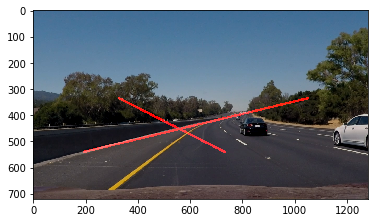

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))